


# Document Similarity with Latent Semantic Analysis (LSA)

The following notebook walks you through doing LSA document similarity in Python. We then output the document similarity matrix as a .csv file which can be manipulated to highlight similarity between documents. We also output a heatmap which gives an initial impression of the similarity between documents. 

###  Before we begin
Before we start, you will need to have set up a [Carbonate account](https://kb.iu.edu/d/aolp) in order to access [Research Desktop (ReD)](https://kb.iu.edu/d/apum). You will also need to have access to ReD through the [thinlinc client](https://kb.iu.edu/d/aput). If you have not done any of this, or have only done some of this, but not all, you should go to our [textPrep-Py.ipynb](https://github.com/cyberdh/Text-Analysis/blob/drafts/textPrep-Py.ipynb) before you proceed further. The textPrep-Py notebook provides information and resources on how to get a Carbonate account, how to set up ReD, and how to get started using the Jupyter Notebook on ReD.   

### Run CyberDH environment
The code in the cell below points to a Python environment specificaly for use with the Python Jupyter Notebooks created by Cyberinfrastructure for Digital Humanities. It allows for the use of the different pakcages in our notebooks and their subsequent data sets.

##### Packages
- **sys:** Provides access to some variables used or maintained by the interpreter and to functions that interact strongly with the interpreter. It is always available.
- **os:** Provides a portable way of using operating system dependent functionality.

#### NOTE: This cell is only for use with Research Desktop. You will get an error if you try to run this cell on your personal device!!

In [1]:
import sys
import os
sys.path.insert(0,"/N/u/cyberdh/Carbonate/dhPyEnviron/lib/python3.6/site-packages")
os.environ["NLTK_DATA"] = "/N/u/cyberdh/Carbonate/dhPyEnviron/nltk_data"

### Include necessary packages for notebook 

Python's extensibility comes in large part from packages. Packages are groups of functions, data, and algorithms that allow users to easily carry out processes without recreating the wheel. Some packages are included in the basic installation of Python, others created by Python users are available for download. Make sure to have the following packages installed before beginning so that they can be accessed while running the scripts.

In your terminal, packages can be installed by simply typing `pip install nameofpackage --user`. However, since you are using ReD and our Python environment, you will not need to install any of the packages below to use this notebook. Anytime you need to make use of a package, however, you need to import it so that Python knows to look in these packages for any functions or commands you use. Below is a brief description of the packages we are using in this notebook:  

- **sklearn:** Simple and efficient tools for data mining and data analysis built on NumPy, SciPy, and matplotlib.
- **pandas:** An open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.
- **warnings:** Allows for the manipulation of warning messages in Python.
- **numpy:** a general-purpose array-processing package designed to efficiently manipulate large multi-dimensional arrays of arbitrary records without sacrificing too much speed for small multi-dimensional arrays. 
- **string:** Contains a number of functions to process standard Python strings.
- **nltk:** A leading platform for building Python programs to work with human language data.
- **seaborn:** a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics.
- **matplotlib:** Produces publication quality 2D graphics for interactive graphing, scientific publishing, user interface development and web application servers targeting multiple user interfaces and hardcopy output formats.

Notice we import some of the packages differently. In some cases we just import the entire package when we say `import XYZ`. For some packages which are small, or, from which we are going to use a lot of the functionality it provides, this is fine. 

Sometimes when we import the package directly we say `import XYZ as X`. All this does is allow us to type `X` instead of `XYZ` when we use certain functions from the package. So we can now say `X.function()` instead of `XYZ.function()`. This saves time typing and eliminates errors from having to type out longer package names. I could just as easily type `import XYZ as potato` and whenever I use a function from the `XYZ` package I would need to type `potato.function()`. What we import the package as is up to you, but some commonly used packages have abbreviations that are standard amongst Python users such as `import pandas as pd` or `import matplotlib.pyplot as plt`. You do not need to us `pd` or `plt`, however, these are widely used and using something else could confuse other users and is generally considered bad practice. 

Other times we import only specific elements or functions from a package. This is common with packages that are very large and provide a lot of functionality, but from which we are only using a couple functions or a specific subset of the package that contains the functionality we need. This is seen when we say `from XYZ import ABC`. This is saying I only want the `ABC` function from the `XYZ` package. Sometimes we need to point to the specific location where a function is located within the package. We do this by adding periods in between the directory names, so it would look like `from XYZ.123.A1B2 import LMN`. This says we want the `LMN` function which is located in the `XYZ` package and then the `123` and `A1B2` directory in that package. 

You can also import more than one function from a package by separating the functions with commas like this `from XYZ import ABC, LMN, QRS`. This imports the `ABC`, `LMN` and `QRS` functions from the `XYZ` package.

In [2]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import warnings
import numpy as np
import string
import nltk
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt

This will ignore deprecation and future warnings. All the warnings in this code are not concerning and will not break the code or cause errors in the results.

In [3]:
# Suppress warnings from pandas library
warnings.filterwarnings("ignore", category=DeprecationWarning,
                        module="pandas", lineno=570)
warnings.filterwarnings("ignore", category=FutureWarning,
                        module = "sklearn", lineno = 1059)
warnings.filterwarnings("ignore", category=UserWarning,
                        module = "sklearn", lineno = 300)

### Getting your data

#### File paths
Here we are saving as variables different file paths that we need in our code. We do this so that they are easier to call later and so that you can make most of your changes now and not need to make as many changes later. 

First we use the `os` package above to find our `["HOME"]` directory using the `environ` function. This will work for any operating system, so if you decide to try this out on your personal computer instead of ReD, the `homePath` variable will still be the path to your 'home' directory, so no changes are needed.

Next, we combine the `homePath` variable with the folder names that lead to where our data is stored. Note that we do not use any file names yet, just the path to the folder. This is because we are comparing documents to one another, so we need to read in an entire directory. You will want to change the folder names to match your folder names in your file path.

Now we add the `homePath` variable to other folder names that lead to a folder where we will want to save any output generated by this code. You again will want to change the file names in the path to match your own file names. We save this file path as the variable `dataResults`.

In [4]:
homePath = os.environ["HOME"]
dataHome = os.path.join(homePath, "Text-Analysis-master", "data", "shakespeareDated")
dataResults = os.path.join(homePath, "Text-Analysis-master", "Output")

#### Set needed variables

Now we are setting needed variables that will help determine what the code will do farther down. Just like the file path variables, this is done so you have to make fewer changes later and also to make the changes easier to find by putting them in one place.

If you want to use the stopword list that comes with the nltk package then set `nltkStop` equal to **True**. If you do not wish to use the nltk stopword list then set `nltkStop` equal to **False**.

If you have created your own custom stopword list and wish to use that, then set `customStop` equal to **True**. If you do not have your own custom stopword list then set `customStop` equal to **False**.

**NOTE: You can use both the nltk and custom stopword lists or you can use neither or just one or the other. You do NOT need to set them both to True or both to False. Use whatever works best for you.**

Next we decide if we want to stem our words. Stemming words will remove certain endings of words leaving you with the root of the word. So "reads" becomes "read" as does "reading" and "reader". This will probably increase the similarity of documents as they will then share more words in common. If you want to stem the words in your dataset the assign `True` to the variable `stem`. If you do not wish to stem your words then assign `False` to the variable `stem`.

Then we decide if we want all the words in our dataset lowercased. This will change "Love" to "love" so that it is recognized as the same word for similarity purposes. However, there are some cases where the use of capitalization may be important to determining similarity, so we have the option to lowercase or not. If you want to lowercase all the words in your dataset assign `True` to the variable `lower`. If you do not wish to lowercase all the words in your dataset then assign `False` to the variable `lower`.

Now we choose the language we will be using for the nltk stopwords list and the nltk stemmer. If you need a different language, simply change 'english' (keep the quotes) in the `language` variable to the anglicized name of the language you wish to use (e.g. 'spanish' instead of 'espanol' or 'german' instead of 'deutsch').

The variable `encoding` is where you determine what type of encoding to use (ascii, ISO-8850-1, utf-8, etc...). We have it set to utf-8 at the moment as we have found it is less likely to have any problems. However, errors do occur, but the encoding errors rarely impact our results and it causes the Python code to exit. So instead of dealing with unhelpful errors we ignore the ones dealing with encoding by assigning `'ignore'` to the `errors` variable.

The `stopWords =[]` variable is simply an empty list. This is where the words from the nltk stopword list or your custom stopword list or both combined or neither (depending on what you decide) will reside later on. You do not need to do anything to this line of code.

The `tokenDict = {}` variable is an empty dictionary. This is where your documents will reside later. The file name for the document will be the key and the content of the document will be the value. This will be explained in more detail later. For now, you do not need to do anything to this line.

In [5]:
nltkStop = True
customStop = True
stem = True
lowerCase = True
language = 'english'
encoding = 'utf-8'
errors = 'ignore'
stopWords = []
tokenDict = {}

### Stopwords
If you set `nltkStop` equal to **True** above then this will add the NLTK stopwords list to the empty list named `stopWords`.

You should have already chosen your desired language above, but if you wish to add any words to the stopWords list then add the word(s) you want as a stop word in the `stopWords.extend(['words', 'you', 'want', 'to', 'add'])` part of the code.

In [6]:
if nltkStop is True:
    # NLTK Stop words
    stopWords = stopwords.words(language)

    stopWords.extend(['would', 'said', 'says', 'also'])

#### Add own stopword list

Here is where your own stopwords list is added if you set `customStop` equal to **True** above. Here you will need to change the folder names and file name to match your folders and file. Remember to put each folder name in quotes and in the correct order always putting the file name including the file extension (.txt) last.

In [7]:
if customStop is True:
    stopWordsFilepath = os.path.join(homePath, "Text-Analysis-master", "data", "earlyModernStopword.txt")

    with open(stopWordsFilepath, "r",encoding = encoding, errors = errors) as f:
        stopWordsList = [x.strip() for x in f.readlines()]

    stopWords.extend(stopWordsList)

#### Dictionary and stemmer
Here we save the word stemmer we are using as the variable `stemmer`. 

The stemmer will truncate endings of words that end in 'ing' or 's' or 'es' et cetera. This will help ensure that words such as 'reading' and 'read' are considered as the same word so that the concept of 'to read' is given equal consideration. You should have already chosen your desired language up above.

In [8]:
if stem is True:
    stemmer = SnowballStemmer(language)

### Functions
We need to create a function in order to stem and tokenize our data. Any time you see `def` that means we are **DE**claring a **F**unction. The `def` is usually followed by the name of the function being created and then in parentheses are the parameters required by the function. After the parentheses is a colon, which closes the declaration, then a bunch of code below which is indented. The indented code is the program statement or statements to be executed. Once you have created your function all you need to do in order to run it is call the function by name and make sure you have included all the required parameters in the parentheses. This allows you to call the function without having to write out all the code in the function every time you wish to perform that task.

#### Stemming and tokenization functions
Here we create two functions. The first is where we will use the `stemmer` variable above to create a function that will stem the words in our documents when applied.

The second tokenizes our documents which means it splits it into individual words. This function uses the `stemTokens` function as part of it so later in the code we will only need to apply the `tokenize` function. 

You should not need to make any changes to this block of code.

In [9]:
if stem is True:
    def stemTokens(tokens, stemmer):
        stemmed = []
        for item in tokens:
            stemmed.append(stemmer.stem(item))
        return stemmed

    def tokenize(text):
        tokens = nltk.word_tokenize(text)
        stems = stemTokens(tokens, stemmer)
        return stems

else:
    def tokenize(text):
        tokens = nltk.word_tokenize(text)
        return tokens

#### Read in documents
Now we read in our documents and also perform some text cleaning. This code lower cases all the words as well as removes punctuation. Then it adds the file names and cleaned content of each file to our previously empty `tokenDict` dictionary above. You should not need to make any changes to this code.

A dictionary is similar to a list except it has what are called 'keys' and 'values'. This basically allows us to label our data. In this case we will be making the file names of our documents the 'keys' and the content of the file the 'values' so that each document name correlates to the content of that document.

In [10]:
for subdir, dirs, files in os.walk(dataHome):
    for file in files:
        if file.startswith('.'):
                continue
        filePath = subdir + os.path.sep + file
        with open(filePath, 'r', encoding = encoding, errors = errors) as textFile:
            text = textFile.read()
            if lowerCase is True:
                lowers = text.lower()
                noPunctuation = lowers.translate(str.maketrans('','', string.punctuation))
                tokenDict[file] = noPunctuation
            else:
                noPunctuation = text.translate(str.maketrans('','', string.punctuation))
                tokenDict[file] = noPunctuation

Let's check and see if our dictionary now has our data. We are asking to see the first 10 keys of our dictionary.

In [11]:
print(list(tokenDict.keys())[0:10])

['1610Cymbeline.txt', '1596MerchantOfVenice.txt', '1604AllsWellThatEndsWell.txt', '1591KingHenry6_3.txt', '1599JuliusCaesar.txt', '1600TroilusAndCressida.txt', '1605TimonOfAthens.txt', '1592KingRichard3.txt', '1591KingHenry6_2.txt', '1603MeasureForMeasure.txt']


#### Tfidf Vectorizer

Here we weight the importance of each word in the document. This is done using Term Frequency-Inverse Document Frequency (Tfidf). This considers how important a word is based on the frequency in the whole corpus as well as in individual documents. This allows for words that might not have a high frequency in an entire collection, but do have a high frequency in one or two documents when compared to other words to still be given a higher level of importance throughout the text.

In [12]:
vectorizer = TfidfVectorizer(tokenizer = tokenize, stop_words=stopWords)
dtm = vectorizer.fit_transform(tokenDict.values())
testDF = pd.DataFrame(dtm.toarray(), index=tokenDict.keys(), columns = vectorizer.get_feature_names())
testDF = testDF.sort_index(axis = 0)

Now let's take a look at our data frame where the rows are the documents and the columns are the terms. To adjust which part of the data frame you see in the output change the numbers in the square brackets. To see the 10th thru the 20th row and the 100th to 110th column the numbers in the brackets should read `[10:20, 100:110]`. So the first set of numbers is for what rows you wish to see and the second set dictate the columns. 

In [13]:
testDF.iloc[:10, 7640:7650]

,massacr,massi,mast,master,mastercord,masterdom,mastergunn,masterleav,masterless,masterpiec
1589TwoGentlemenOfVerona.txt,0.000000,0.0,0.000000,0.079115,0.0,0.0,0.000000,0.0,0.0,0.0
1590TamingOfTheShrew.txt,0.000000,0.0,0.000000,0.104583,0.0,0.0,0.000000,0.0,0.0,0.0
1591KingHenry6_1.txt,0.015566,0.0,0.000000,0.012101,0.0,0.0,0.006773,0.0,0.0,0.0
1591KingHenry6_2.txt,0.000000,0.0,0.000000,0.051486,0.0,0.0,0.000000,0.0,0.0,0.0
1591KingHenry6_3.txt,0.000000,0.0,0.006464,0.010712,0.0,0.0,0.000000,0.0,0.0,0.0
1591TitusAndronicus.txt,0.009424,0.0,0.000000,0.006279,0.0,0.0,0.000000,0.0,0.0,0.0
1592KingRichard3.txt,0.008609,0.0,0.003462,0.012907,0.0,0.0,0.000000,0.0,0.0,0.0
1594ComedyOfErrors.txt,0.000000,0.0,0.013904,0.146888,0.0,0.0,0.000000,0.0,0.0,0.0
1594LovesLaboursLost.txt,0.000000,0.0,0.000000,0.059978,0.0,0.0,0.000000,0.0,0.0,0.0
1595KingRichard2.txt,0.000000,0.0,0.000000,0.003632,0.0,0.0,0.000000,0.0,0.0,0.0


The below code outputs the first 10 words that make up the columns once we have broken our corpus down into a Tfidf matrix. To output all of the words remove the square brackets and their contents in the `print(vectGFN[:20])` line of code. To change the number of words printed change `20` in the same line to the number of words you wish to see.

In [14]:
# Get words that correspond to each column
vectGFN = vectorizer.get_feature_names()
print(vectGFN[:20])

['2d', '2s', '4d', '5s', '6d', '8d', 'aaron', 'abandon', 'abas', 'abash', 'abat', 'abatfowl', 'abbess', 'abbey', 'abbot', 'abbrevi', 'abc', 'abe', 'abel', 'abergavenni']


#### Run SVD and Cosine Similarity

Here we run our Tfidf matrix created above through Singular Value Decomposition and then calculate the Cosine Similarity of the documents to one another. 

Singular Value Decomposition condenses our Tfidf matrix down a bit to make it easier to process. Here we also set the number of dimensions (`n_components`) , how many times we iterate over the corpus (`n_iter`), and then set the seed (`random_state`) so that the results are reproducable. At the moment the `random_state` is set to 42 which sets the seed for the random number generator, but feel free to adjust the number to get a slightly different output. Just make sure you keep the seed the same once you find one you like for reproducibility.

Cosine similarity is where we measure how similar the documents are to one another. The result is a number between -1 and 1 with 1 being a perfect match (which we will get when the document is compared to itself) and -1 being completely different which we might get if we have a document of all numbers and one of all words with no numbers at all. Usually, even documents that are about unrelated topics share some common words and so are not completely dissimilar.

In [15]:
lsa = TruncatedSVD(n_components = 100, n_iter = 1000, random_state = 42)
dtmLsa = lsa.fit_transform(dtm)
cosineSim = cosine_similarity(dtmLsa)

#### Save as a data frame

Now we save the results as a data frame. First we name the output .csv file so it matches our data. We do this in the first line of the cell.

Next we add color based on the numbers in the data frame cells, so right now we have it set so that the more dissimilar the more red the cell will be and the more similar the more green it will be with those in the middle looking more yellow. You can adjust the colors by changing the `colorChoice` variable to something else. Options for colors can be found here: [https://matplotlib.org/tutorials/colors/colormaps.html](https://matplotlib.org/tutorials/colors/colormaps.html) 

Then we create the data frame and say we want the rows and columns to be labeled with the file names. Then we sort the columns in alphanumeric order by column header, then we sort the rows alphanumericaly by row label.  

In [16]:
csvFileName = "docSimilarityMatrix.csv"

df = pd.DataFrame(cosineSim, index = tokenDict.keys(), columns=tokenDict.keys())
dfS = df[sorted(df)]
sortedDf = dfS.sort_index(axis = 0)
np.fill_diagonal(sortedDf.values, np.nan)
sortedDf.to_csv(os.path.join(dataResults, csvFileName))
sortedDf

,1589TwoGentlemenOfVerona.txt,1590TamingOfTheShrew.txt,1591KingHenry6_1.txt,1591KingHenry6_2.txt,1591KingHenry6_3.txt,1591TitusAndronicus.txt,1592KingRichard3.txt,1594ComedyOfErrors.txt,1594LovesLaboursLost.txt,1595KingRichard2.txt,...,1604AllsWellThatEndsWell.txt,1605KingLear.txt,1605TimonOfAthens.txt,1606AnthonyAndCleopatra.txt,1606Macbeth.txt,1608Coriolanus.txt,1609WintersTale.txt,1610Cymbeline.txt,1610Tempest.txt,1612KingHenry8.txt
1589TwoGentlemenOfVerona.txt,NaN,0.345181,0.275569,0.307060,0.285913,0.304649,0.382377,0.335455,0.451381,0.345359,...,0.466530,0.429107,0.302893,0.277577,0.293129,0.298539,0.385161,0.398809,0.337616,0.346503
1590TamingOfTheShrew.txt,0.345181,NaN,0.286906,0.329936,0.294245,0.314526,0.393628,0.397346,0.420519,0.357273,...,0.473181,0.465000,0.309654,0.294149,0.327447,0.326321,0.433565,0.419965,0.373001,0.376074
1591KingHenry6_1.txt,0.275569,0.286906,NaN,0.621439,0.521432,0.353902,0.555755,0.304439,0.381562,0.516789,...,0.473760,0.490358,0.352947,0.290945,0.334898,0.307191,0.407332,0.423994,0.376624,0.461969
1591KingHenry6_2.txt,0.307060,0.329936,0.621439,NaN,0.649832,0.393857,0.658161,0.366957,0.431173,0.616805,...,0.529999,0.561097,0.392233,0.332750,0.389203,0.339563,0.473541,0.476565,0.428213,0.568354
1591KingHenry6_3.txt,0.285913,0.294245,0.521432,0.649832,NaN,0.361198,0.646881,0.308282,0.376892,0.558686,...,0.443772,0.472828,0.317543,0.290717,0.338977,0.295834,0.419000,0.423896,0.387350,0.435948
1591TitusAndronicus.txt,0.304649,0.314526,0.353902,0.393857,0.361198,NaN,0.465840,0.327555,0.375961,0.441442,...,0.441230,0.460782,0.341802,0.329979,0.327522,0.420358,0.409575,0.458850,0.371782,0.369224
1592KingRichard3.txt,0.382377,0.393628,0.555755,0.658161,0.646881,0.465840,NaN,0.413933,0.505384,0.684725,...,0.619335,0.613880,0.461315,0.390686,0.449436,0.397575,0.561243,0.557826,0.486407,0.617343
1594ComedyOfErrors.txt,0.335455,0.397346,0.304439,0.366957,0.308282,0.327555,0.413933,NaN,0.417126,0.390022,...,0.486151,0.486942,0.342464,0.311604,0.358105,0.352861,0.443288,0.450111,0.409762,0.384307
1594LovesLaboursLost.txt,0.451381,0.420519,0.381562,0.431173,0.376892,0.375961,0.505384,0.417126,NaN,0.494092,...,0.593664,0.553617,0.395425,0.374950,0.395195,0.387129,0.519618,0.513104,0.435321,0.506127
1595KingRichard2.txt,0.345359,0.357273,0.516789,0.616805,0.558686,0.441442,0.684725,0.390022,0.494092,NaN,...,0.567524,0.593726,0.416413,0.372931,0.450775,0.392933,0.529182,0.537093,0.479825,0.571275


### Plot Heatmap

Now we plot a heatmap and save it as a .png file for use in a paper, presentation, or even a website. 

First, we name the output file of the heatmap which is in the variable `heatmapFileName`. 

Next we choose the dpi level we want the output to be. We have it set to 300 which is generally good for both print and website use. 

Then we choose the color scheme we want. At the moment we have one where green represents the highest number (most similar) and red represents the lowest numbers (least similar) with yellow being more in the middle. If another color scheme would work better for you other options for color schemes can be found here: [https://matplotlib.org/tutorials/colors/colormaps.html](https://matplotlib.org/tutorials/colors/colormaps.html)

Now we choose the font size. This will depend on your data and the size of your heatmap, so you'll want to play around with the number in `fontScale` until you find a value that works with your heatmap. 


Now we plot our heatmap!

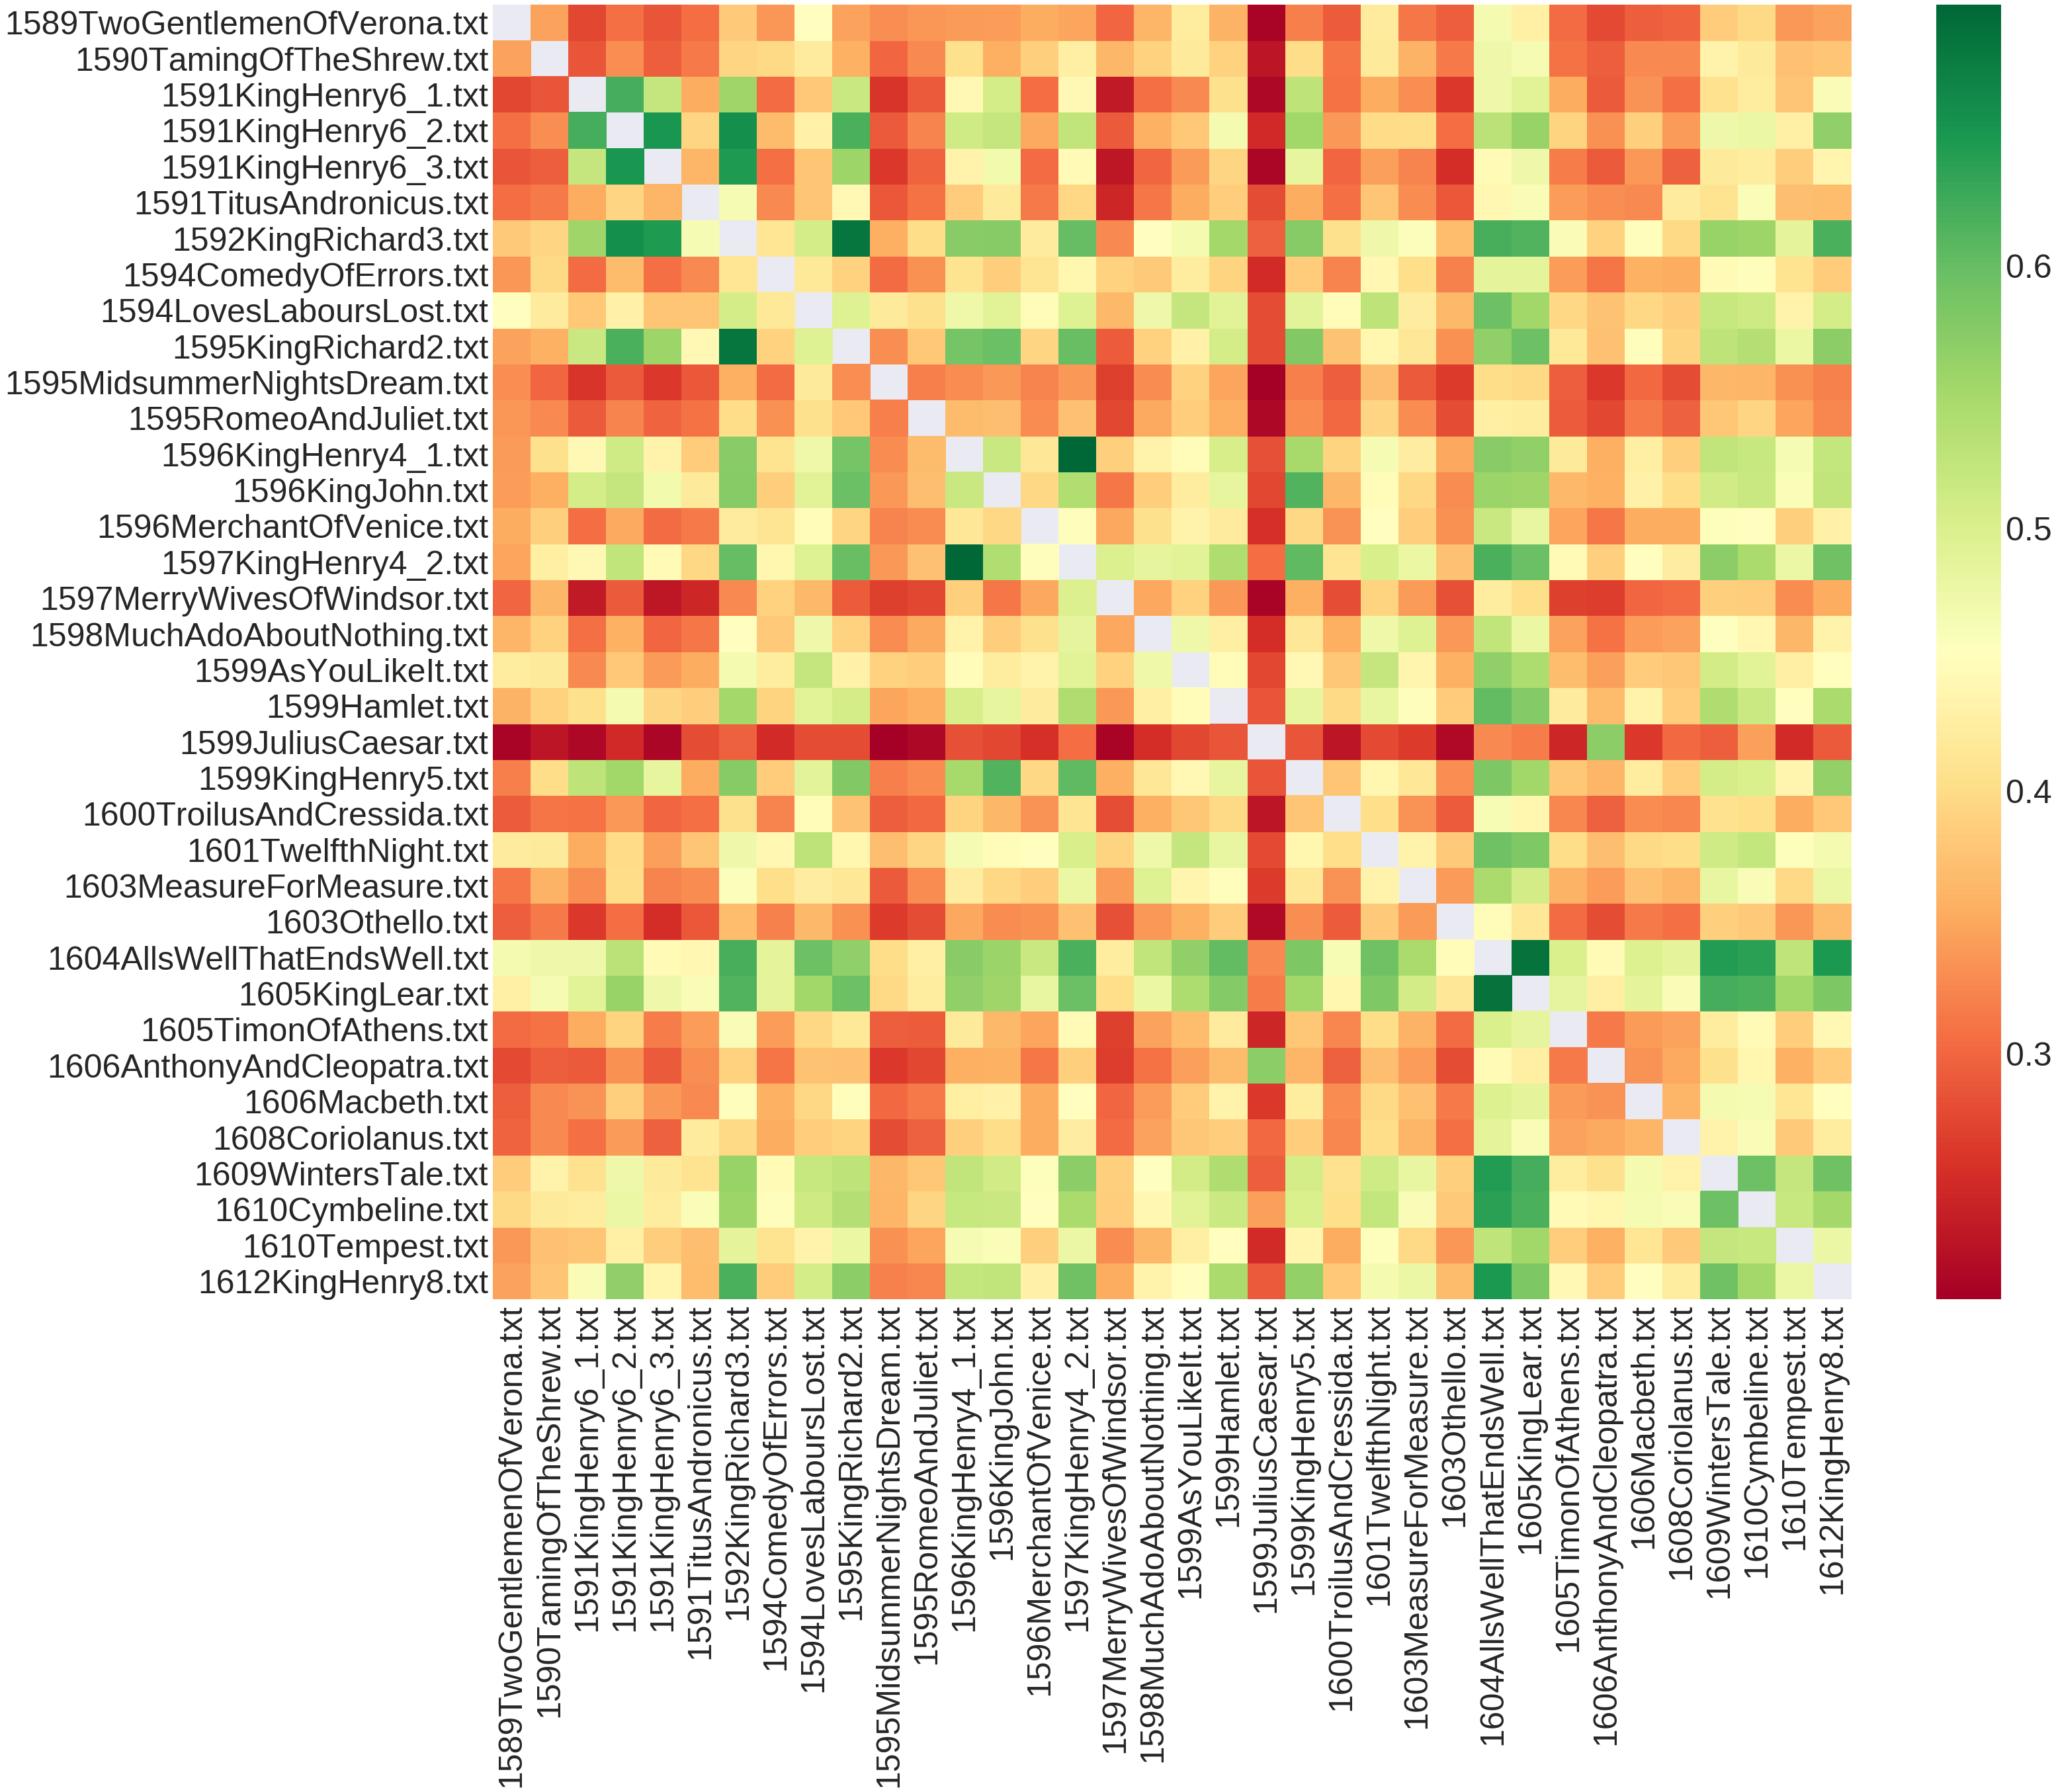

In [17]:
#Variables
heatmapFileName = 'DocSimHeatmap.svg'
dpi = 600
colorScheme = 'RdYlGn'
fontScale = 5

# Plot
figureSize = len(sortedDf)
sns.set(rc={'figure.figsize':(figureSize + 10, figureSize)}, font_scale = fontScale)
ax = sns.heatmap(sortedDf, cmap = colorScheme)
ax.figure.savefig(os.path.join(dataResults, heatmapFileName), dpi = dpi, bbox_inches='tight')
plt.show()

## VOILA!!

This notebook was adapted from https://www.datascienceassn.org/sites/default/files/users/user1/lsa_presentation_final.pdf at Colorado University, Boulder. Accessed on 02/01/2019.